In [29]:
import sys
import os
from IPython.display import Image, display
from langgraph.graph import StateGraph
# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from agents.engineering_codegen.code_generator import compiled_graph as code_generator
from agents.engineering_codegen.code_generator import QuestionPayload,QuestionPackage


## Visualize the graph 

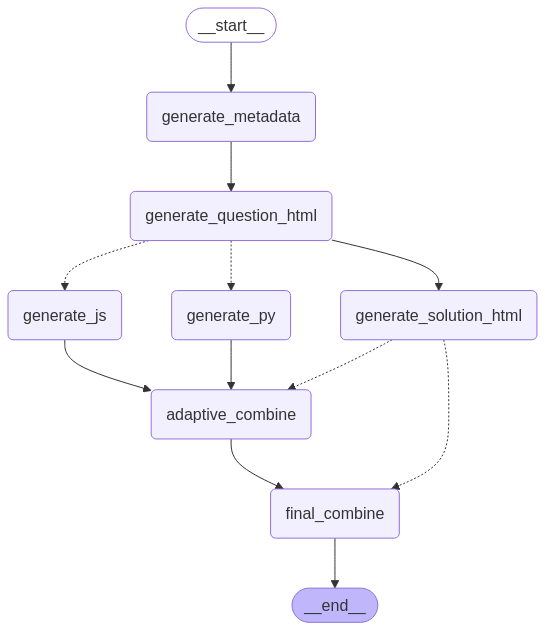

In [21]:
def show_graph_visualization(
    graph: StateGraph, filename: str = "CodeBuilder.png"
) -> None:
    """
    Visualizes the graph and saves it as a PNG image.

    Args:
        graph: The StateGraph instance.
        filename: The filename to save the image.
    """
    try:
        image_bytes = graph.get_graph().draw_mermaid_png()
        display(Image(image_bytes))
    except Exception as error:
        print(f"Graph visualization failed: {error}")
        
show_graph_visualization(code_generator)

## Running the Graph
The code generator expects input in the form of a Pydantic model named `QuestionPackage`. This model stores all relevant data—including files, metadata, and the input question. All these values are either generated automatically or are optional. The only required field is `QuestionPayload`, which contains the details of the question. Optionally, `QuestionPayload` may also include a solution guide and additional instructions.

In [75]:
import json
print(json.dumps(QuestionPackage.model_json_schema(), indent=2))

{
  "$defs": {
    "FilesData": {
      "description": "Holds the generated file contents related to a question.",
      "properties": {
        "question_html": {
          "default": "",
          "title": "Question Html",
          "type": "string"
        },
        "server_js": {
          "default": "",
          "title": "Server Js",
          "type": "string"
        },
        "server_py": {
          "default": "",
          "title": "Server Py",
          "type": "string"
        },
        "solution_html": {
          "default": "",
          "title": "Solution Html",
          "type": "string"
        },
        "metadata": {
          "default": {},
          "title": "Metadata",
          "type": "object"
        }
      },
      "title": "FilesData",
      "type": "object"
    },
    "InitialMetadata": {
      "properties": {
        "createdBy": {
          "title": "Createdby",
          "type": "string"
        },
        "qtype": {
          "title": "Qtype",
      

In [33]:
print(json.dumps(QuestionPayload.model_json_schema(), indent=2))

{
  "properties": {
    "question": {
      "description": "The complete, standalone question intended for conversion into educational content.",
      "title": "Question",
      "type": "string"
    },
    "solution_guide": {
      "anyOf": [
        {
          "type": "string"
        },
        {
          "type": "null"
        }
      ],
      "default": null,
      "description": "A comprehensive, step-by-step explanation detailing the method to solve the question.",
      "title": "Solution Guide"
    },
    "additional_instructions": {
      "anyOf": [
        {
          "type": "string"
        },
        {
          "type": "null"
        }
      ],
      "default": null,
      "description": "Specific directives or preferences provided by the user regarding the presentation, constraints, or other aspects of the question.",
      "title": "Additional Instructions"
    }
  },
  "required": [
    "question"
  ],
  "title": "QuestionPayload",
  "type": "object"
}


In [34]:
question_payload = {
        "question": (
            "What is the final velocity of a 2 kg projectile launched at 30 degrees "
            "with an initial speed of 20 m/s after 3 seconds?"
        ),
        "solution_guide": None,
        "additional_instructions": None,
    }

graph_input = QuestionPackage(question_payload=question_payload)
result = await code_generator.ainvoke(graph_input)

Running Adaptive Combine


In [55]:
print(json.dumps(dict(result.get("question_payload")), indent=2))
print(json.dumps(dict(result.get("files")), indent=2))


{
  "question": "What is the final velocity of a 2 kg projectile launched at 30 degrees with an initial speed of 20 m/s after 3 seconds?",
  "solution_guide": null,
  "additional_instructions": null
}
{
  "question_html": "<pl-question-panel>\n  <p> A projectile is launched at an angle of {{params.angle}} degrees with an initial speed of {{params.initial_speed}} {{params.unitsSpeed}} after {{params.time}} seconds. \n  <p> Determine the final velocity (in {{params.unitsSpeed}}) of the projectile after the given time.</p>\n</pl-question-panel>\n\n<pl-number-input answers-name=\"final_velocity\" comparison=\"sigfig\" digits=\"3\" label=\"$v_f=$ (in {{params.unitsSpeed}})\"></pl-number-input>\n\n<pl-number-input answers-name=\"angle\" comparison=\"sigfig\" digits=\"3\" label=\"Angle (in degrees)\"></pl-number-input>\n<pl-number-input answers-name=\"initial_speed\" comparison=\"sigfig\" digits=\"3\" label=\"$v_0=$ (in {{params.unitsSpeed}})\"></pl-number-input>\n<pl-number-input answers-nam

## Running Multiple questions

In [72]:
question_payloads = [
    {
        "question": (
            "What is the final velocity of a 2 kg projectile launched at 30 degrees "
            "with an initial speed of 20 m/s after 3 seconds?"
        ),
        "solution_guide": None,
        "additional_instructions": None,
    },
    {
        "question": (
            "A block of mass 5 kg is sliding down a frictionless incline at an angle of 25 degrees. "
            "What is the acceleration of the block?"
        ),
        "solution_guide": None,
        "additional_instructions": None,
    },
    {
        "question": (
            "Calculate the heat required to raise the temperature of 500g of water "
            "from 25°C to 75°C. Assume the specific heat of water is 4.18 J/g°C."
        ),
        "solution_guide": None,
        "additional_instructions": None,
    },
]
tasks = []
for q in question_payloads:
    print(q)
    graph_input = QuestionPackage(question_payload=q)
    tasks.append(code_generator.ainvoke(graph_input))
import asyncio
results = await asyncio.gather(*tasks)
    

{'question': 'What is the final velocity of a 2 kg projectile launched at 30 degrees with an initial speed of 20 m/s after 3 seconds?', 'solution_guide': None, 'additional_instructions': None}
{'question': 'A block of mass 5 kg is sliding down a frictionless incline at an angle of 25 degrees. What is the acceleration of the block?', 'solution_guide': None, 'additional_instructions': None}
{'question': 'Calculate the heat required to raise the temperature of 500g of water from 25°C to 75°C. Assume the specific heat of water is 4.18 J/g°C.', 'solution_guide': None, 'additional_instructions': None}
Running Adaptive Combine
Running Adaptive Combine
Running Adaptive Combine


In [74]:
for r in results:
    print(json.dumps(dict(r.get("question_payload")), indent=2))
    print(json.dumps(dict(r.get("files")), indent=2))

{
  "question": "What is the final velocity of a 2 kg projectile launched at 30 degrees with an initial speed of 20 m/s after 3 seconds?",
  "solution_guide": null,
  "additional_instructions": null
}
{
  "question_html": "<pl-question-panel>\n  <p> A projectile is launched at an angle of {{params.angle}} degrees with an initial speed of {{params.initial_speed}} {{params.unitsSpeed}}. After {{params.time}} seconds, determine the final velocity (in {{params.unitsSpeed}}) of the projectile.</p>\n</pl-question-panel>\n\n<pl-number-input answers-name=\"final_velocity\" comparison=\"sigfig\" digits=\"3\" label=\"$v_f=$ (in {{params.unitsSpeed}})\"></pl-number-input>",
  "server_js": "const math = require('mathjs');\n\n/**\n * The SpeedConverter class provides static methods to convert speeds between\n * different units: feet per second (ft/s), meters per second (m/s),\n * miles per hour (mph), and kilometers per hour (km/h).\n */\nclass SpeedConverter {\n    /**\n     * Converts speed from 